In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import matplotlib.image as mpimg

In [2]:
#Load calibration.p file
with open('calibration.p', 'rb') as handle:
    unserialized_data = pickle.load(handle)

mtx = unserialized_data['mtx']
dist = unserialized_data['dist']

In [3]:
#Undistort Image using mtx and dist matrix from camera calibration
def undistortImage(img, mtx, dist):
    
    undist = cv2.undistort(img, mtx, dist, None)
    return undist

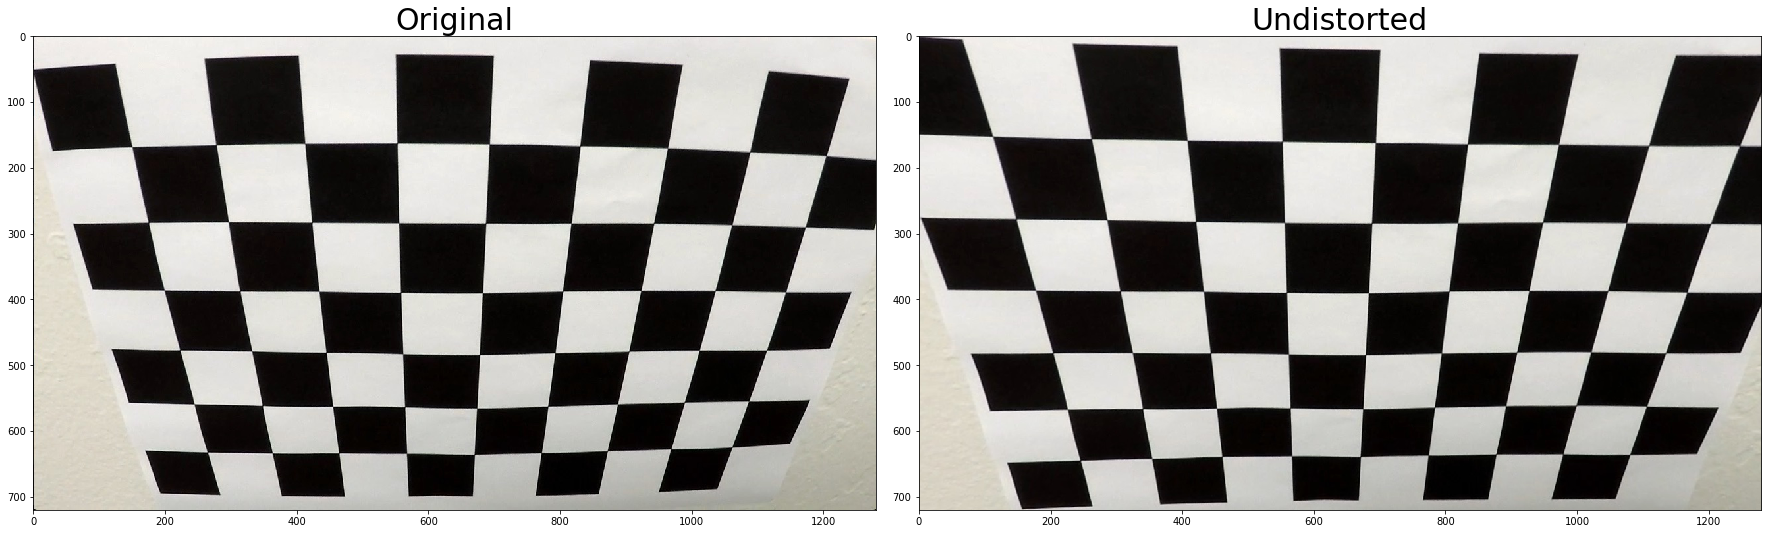

In [4]:
#Exemple of undistortion image
img = mpimg.imread('./camera_cal/calibration2.jpg')
undistorted = undistortImage(img, mtx, dist)

# Plot result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)
f.savefig('./output_images/undistort_calibration.png')
#

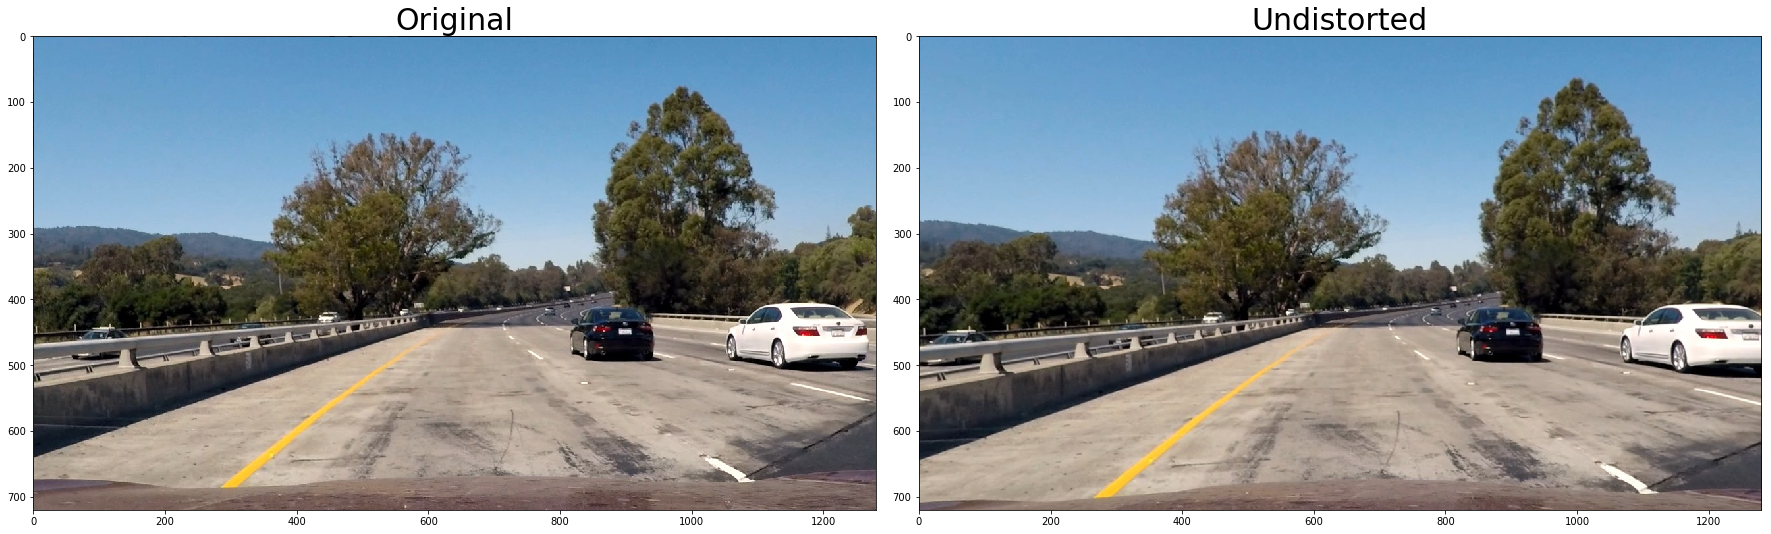

In [5]:
#Apply the same proccess to a road image frame
img = mpimg.imread('./test_images/test1.jpg')

undistort_test = undistortImage(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(undistort_test)
ax2.set_title('Undistorted', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)
f.savefig('./output_images/undistort_road.png')

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def combined(img, ksize=3):
    
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

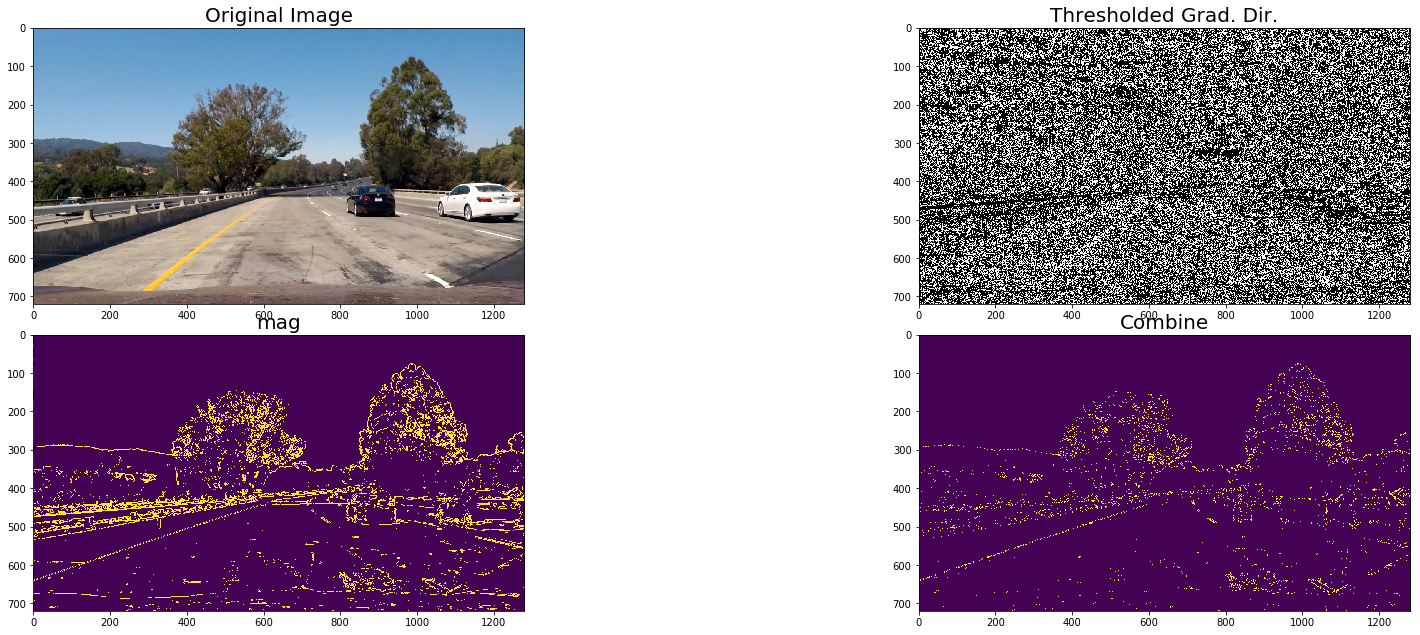

In [7]:

# Plot the result
f, axs = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
axs[0, 0].imshow(img)
axs[0, 0].set_title('Original Image', fontsize=20)
axs[0, 1].imshow(dir_threshold(img, 3, (0.7,1.3)), cmap='gray')
axs[0, 1].set_title('Thresholded Grad. Dir.', fontsize=20)
axs[1, 0].imshow(mag_thresh(img, 3, (30,100)))
axs[1, 0].set_title('mag', fontsize=20)
axs[1, 1].imshow(combined(img))
axs[1, 1].set_title('Combine', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

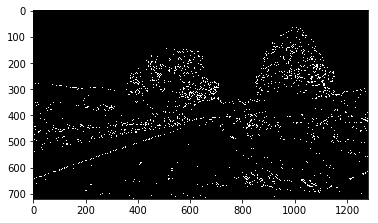

In [8]:
binary_img_result = combined(undistort_test)
plt.imshow(binary_img_result, cmap='gray')
plt.savefig('./output_images/binary_image.png')
plt.show()

In [9]:
#Suggested values for src and dst
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

def warpeImage(img, src, dst, inverse=False):

    img_size = (img.shape[1], img.shape[0])
    
    if not inverse:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)

    warp = cv2.warpPerspective(img, M, img_size)
    return warp, M

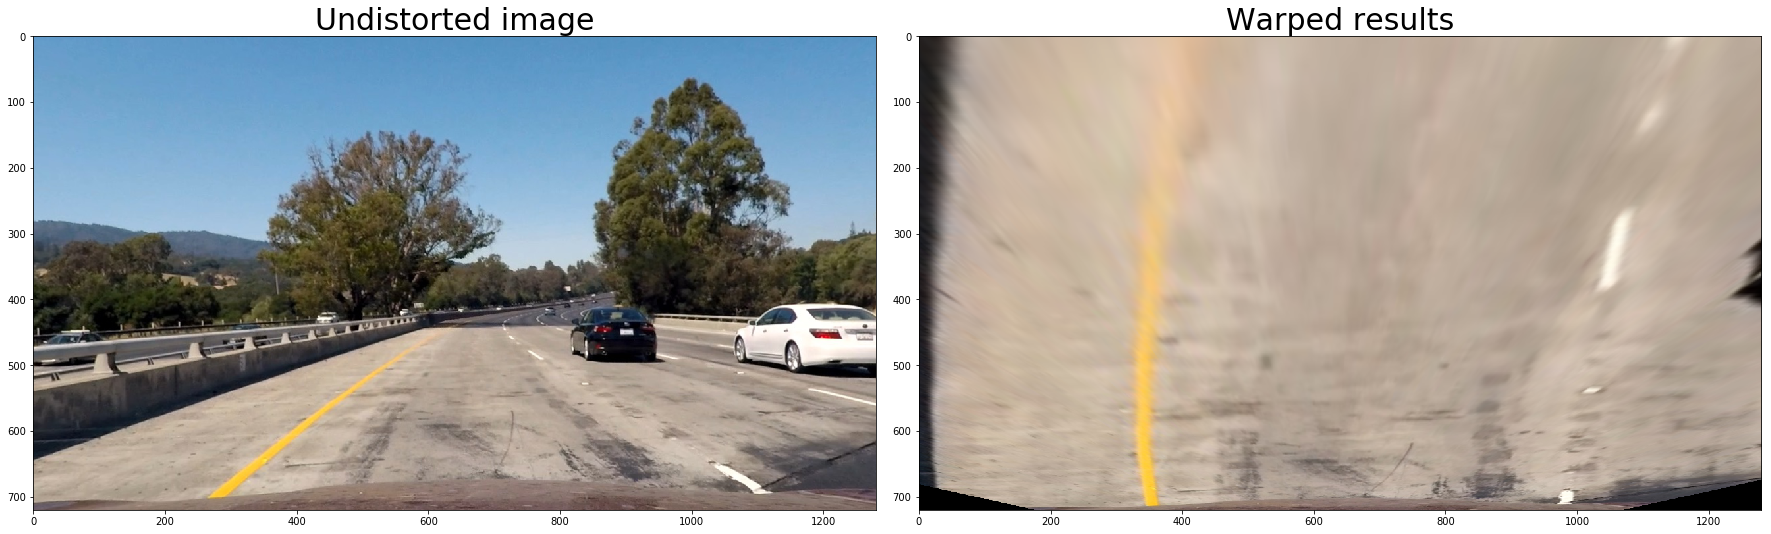

In [10]:
img_size = (img.shape[1], img.shape[0])
dst_image, _ = warpeImage(undistort_test, src, dst)

# Show results:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistort_test)
ax1.set_title('Undistorted image', fontsize=30)
ax2.imshow(dst_image)
ax2.set_title('Warped results', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)
f.savefig('./output_images/warped_image.png')

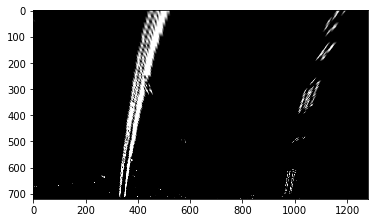

In [11]:
img = mpimg.imread('./test_images/test3.jpg')
undistort_test = undistortImage(img, mtx, dist)

thresholded_img = combined(undistort_test)
warped, _ = warpeImage(thresholded_img, src, dst)

plt.imshow(warped, cmap='gray')
plt.show()

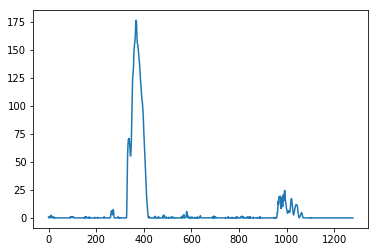

In [12]:
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)
plt.savefig('./output_images/histogram.png')
plt.show()

In [13]:
def getLanes(img):
    histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
    out_img = np.dstack((img, img, img)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 150, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 150, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
        nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
        nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return (leftx, lefty), (rightx, righty), out_img


def polynomialFit(leftpoints, rightpoints):
    left_fit = np.polyfit(leftpoints[1], leftpoints[0], 2)
    right_fit = np.polyfit(rightpoints[1], rightpoints[0], 2)
    return left_fit, right_fit

In [14]:
def plot_fit(src_img, left_fit, right_fit):
    
    fity = np.linspace(0, src_img.shape[0] - 1, src_img.shape[0])
    fit_leftx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
    fit_rightx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]
    return fity, fit_leftx, fit_rightx

def show_lanes_window(src_img, left_points, right_points, left_fit, right_fit, out_img):
    
    fity, fit_leftx, fit_rightx = plot_fit(src_img, left_fit, right_fit)
    out_img[left_points[1], left_points[0]] = [150, 0, 0]
    out_img[right_points[1], right_points[0]] = [0, 0, 150]
    plt.imshow(out_img)
    plt.plot(fit_leftx, fity, color='yellow')
    plt.plot(fit_rightx, fity, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./output_images/window.png')
    plt.show()

In [15]:
left_points, right_points, out_img = getLanes(warped)
left_fit, right_fit = polynomialFit(left_points, right_points)

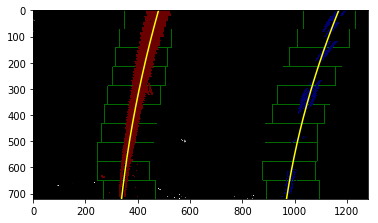

In [16]:
show_lanes_window(warped, left_points, right_points, left_fit, right_fit, out_img)

In [17]:
#Use previus information to predict lane
def lanesPrediction(img, left_fit, right_fit):
    out_img = np.dstack((img, img, img)) * 255
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (
        nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (
        nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty), (rightx, righty), out_img

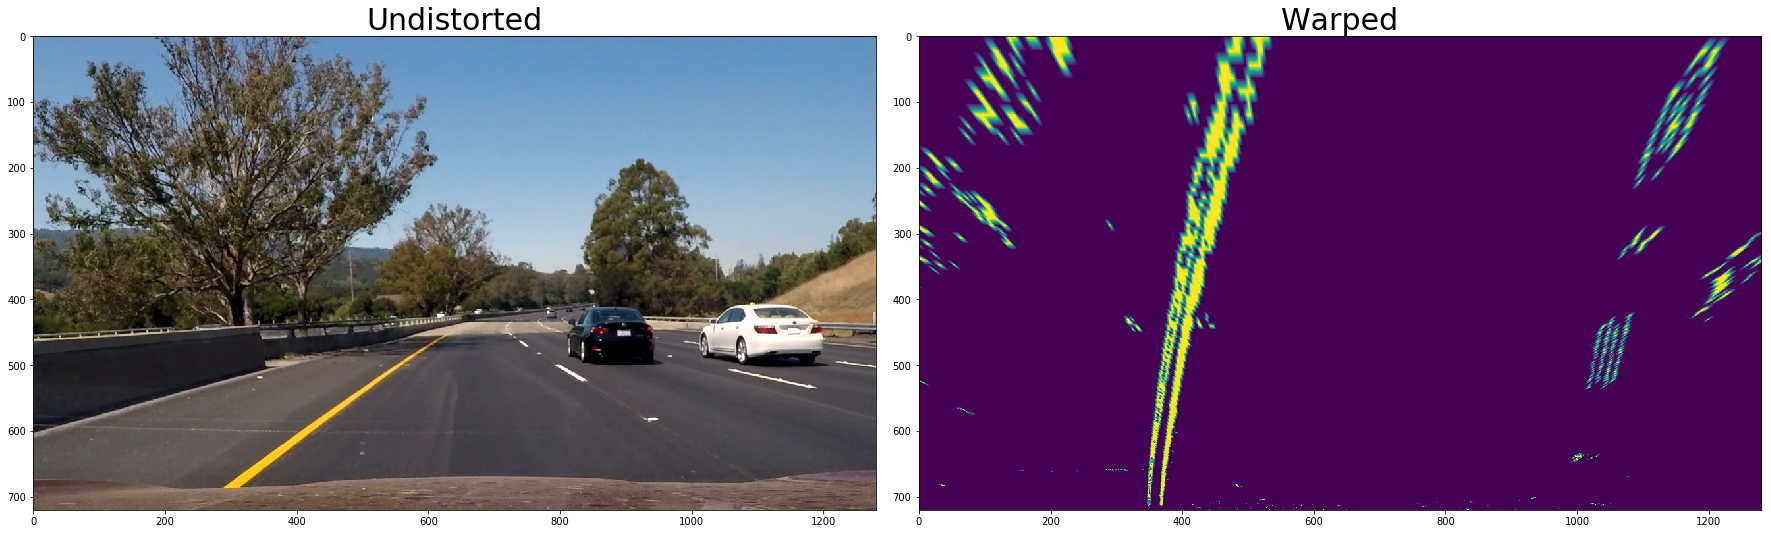

In [18]:
img = mpimg.imread('./test_images/test6.jpg')
undistort_test = undistortImage(img, mtx, dist)
thresholded_img = combined(undistort_test)
binary_warped, _ = warpeImage(thresholded_img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(binary_warped)
ax2.set_title('Warped', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)

left_points, right_points, out_img = lanesPrediction(binary_warped, left_fit, right_fit)
left_fit, right_fit = polynomialFit(left_points, right_points)

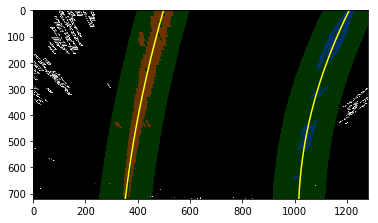

In [19]:
def show_lanes_prediction(img, left_points, right_points, left_fit, right_fit):
    
    fity, fit_leftx, fit_rightx = plot_fit(img, left_fit, right_fit)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[left_points[1], left_points[0]] = [150, 0, 0]
    out_img[right_points[1], right_points[0]] = [0, 0, 150]

    margin = 100
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(fit_leftx, fity, color='yellow')
    plt.plot(fit_rightx, fity, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./output_images/lane_prediction.png')
    plt.show()

show_lanes_prediction(binary_warped, left_points, right_points, left_fit, right_fit)

In [20]:
def calculateRadius_meters(left_points, right_points):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_points[1] * ym_per_pix, left_points[0] * xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_points[1] * ym_per_pix, right_points[0] * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    return left_curverad, right_curverad

left_curverad, right_curverad = calculateRadius_meters(left_points, right_points)
print(left_curverad, 'm', right_curverad, 'm')

1399.01371656 m 525.453149186 m


In [21]:
def calculate_offset(src_img, left_points, right_points):
    left_fit, right_fit = polynomialFit(left_points, right_points)
    _, fit_leftx, fit_rightx = plot_fit(src_img, left_fit, right_fit)
    screen_middel_pixel = src_img.shape[1]/2

    xm_per_pix = 3.7 / 700
    
    left_lane_pixel = fit_leftx[::-1][0]    # x position for left lane
    right_lane_pixel = fit_rightx[::-1][0]   # x position for right lane
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    meters_off_center = xm_per_pix * screen_off_center
    return meters_off_center

meters_off_center = calculate_offset(img, left_points, right_points)
print("Offset: {}m.".format(meters_off_center))

Offset: -0.2325714285714286m.


In [22]:
def drawLanelines(warped, orig_image, left_fit, right_fit):

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    if left_fit is not None and right_fit is not None:
        fity, fit_leftx, fit_rightx = plot_fit(warped, left_fit, right_fit)

        pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
        pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,150, 0))
    _, Minv = warpeImage(warped, src, dst, inverse=True)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    return result

def stats(img, lane_curvature=(None, None), center_offset=None):
    font = cv2.FONT_HERSHEY_SIMPLEX
    if lane_curvature is not (None, None) and center_offset is not None:
        mean_curvature = np.mean(lane_curvature)
        if mean_curvature <= 3000:
            cv2.putText(img, 'Radius = %d (m)' % mean_curvature, (50, 50), font, 1, (255, 255, 255), 2)
        else:
            cv2.putText(img, 'Radius = --- (straight)', (50, 50), font, 1, (255, 255, 255), 2)
        position = 'left' if center_offset < 0 else 'right'
        cv2.putText(img, 'Car is %.2fm %s of center' % (np.abs(center_offset), position), (50, 100), font, 1,
                        (255, 255, 255), 2)
    else:
        cv2.putText(img, 'Lane not found!', (50, 50), font, 1, (150, 0, 0), 2)
    return img

result = drawLanelines(binary_warped, undistort_test, left_fit, right_fit)
result = stats(result, (left_curverad, right_curverad), meters_off_center)

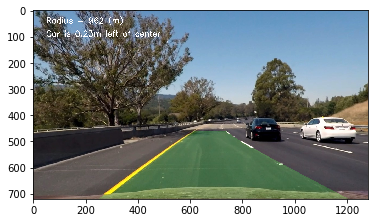

In [23]:
plt.imshow(result)
plt.show()
plt.imsave('./output_images/road_detected.png', result)

In [24]:
def pipeline(img=None, mtx=None, dist=None, data={}):
    undistort = undistortImage(img, mtx, dist)
    thresholded_img = combined(undistort)
    warped, _ = warpeImage(thresholded_img, src, dst)

    if data.get('lanes_bad') or data.get('left_fit') is None or data.get('right_fit') is None:
        left_points, right_points, out_img = getLanes(warped)
    else:
        left_points, right_points, out_img = lanesPrediction(warped, data['left_fit'], data['right_fit'])

    left_fit, right_fit = polynomialFit(left_points, right_points)
    data['lanes_bad'] = False
    data['left_fit'] = left_fit
    data['right_fit'] = right_fit
    data['left_points'] = left_points
    data['right_points'] = right_points
    data['left_line'].append(left_fit)
    data['right_line'].append(left_fit)

    left_curve, right_curve = calculateRadius_meters(left_points, right_points)
    offset = calculate_offset(warped, left_points, right_points)

    lane_img = drawLanelines(warped, img, left_fit, right_fit)
    stats_img = stats(lane_img, (left_curve, right_curve), offset)

    # processed_img = np.copy(lane_img) # remove this after overlay function is done
    return stats_img, data

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

data = {'left_line': deque(maxlen=5),
        'right_line': deque(maxlen=5),
        'left_fit': None,
        'right_fit': None,
        'lanes_bad': True,
        'missed_frames': 0}

def process_image(image):
    global data
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines drawn on lanes)
    result_img, data = pipeline(image, mtx=mtx, dist=dist, data=data)
    return result_img

project_output = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
#project_output = 'challenge_video_processed.mp4'
#clip1 = VideoFileClip("challenge_video.mp4")

project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████████████████████████████████▉| 1260/1261 [07:49<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

Wall time: 7min 50s
